In [1]:
!pip install transformers torch pytorch-crf evaluate datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


# Imports

In [2]:
import urllib.request
import re 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import os
import torch 

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,
    TrainerState, 
    TrainerControl 
)
from datasets import Dataset 
from evaluate import load 


In [3]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: Tesla T4


# 1. Data Loading and Initial Splitting


In [4]:
# Function to load data from a given URL in CoNLL-like format (word \t tag)
def load_data(url, data_type="data"): # Changed default data_type label
    sentences, tags = [], []
    filename = url.split('/')[-1] # Extract filename from URL

    # Check if file already exists locally to avoid unnecessary re-downloading
    if not os.path.exists(filename):
        print(f"Downloading {filename} ({data_type})...")
        try:
            # Download the file from the URL
            urllib.request.urlretrieve(url, filename)
            print(f"Downloaded {filename}")
        except Exception as e:
            # Handle potential download errors
            print(f"Error downloading {filename}: {e}")
            return [], [] # Return empty lists on failure

    print(f"Loading data from {filename}...")
    # Open the file with UTF-8 encoding to handle potential non-ASCII characters
    with open(filename, encoding='utf-8') as f:
        sent, tgs = [], [] # Temporary lists for current sentence and its tags
        # Iterate through each line in the file
        for i, line in enumerate(f):
            line = line.strip() # Remove leading/trailing whitespace

            # Check if the line is empty, signifying the end of a sentence
            if not line:
                # If the current sentence list is not empty, append it to the main lists
                if sent:
                    sentences.append(sent)
                    tags.append(tgs)
                # Reset temporary lists for the next sentence
                sent, tgs = [], []
            else:
                # If the line is not empty, it should contain word and tag data
                parts = line.split("\t") # Split the line by tab character

                # Ensure the line has at least two columns (word and tag)
                if len(parts) >= 2:
                    word, pos = parts[:2] # Take the first two columns as word and tag
                    sent.append(word) # Add word to current sentence
                    tgs.append(pos) # Add tag to current sentence tags
                else:
                    # Skip lines that don't have the expected format (e.g., single column lines)
                    pass # Ignore malformed lines

        # After the loop, add the last sentence if the file didn't end with a blank line
        if sent:
            sentences.append(sent)
            tags.append(tgs)
    print(f"Loaded {len(sentences)} sentences from {filename}.")
    # Return lists of sentences and their corresponding tags
    return sentences, tags


In [5]:
# URLs for the original data files on GitHub
train_url = (
    "https://raw.githubusercontent.com/ltrc/shallow_parsing_in_indian_languages/"
    "main/data/Bengali/bengali-train.txt"
)
test_url = ( 
    "https://raw.githubusercontent.com/ltrc/shallow_parsing_in_indian_languages/"
    "main/data/Bengali/bengali-test.txt"
)

original_train_sents, original_train_tags = load_data(train_url, data_type="original train data")
original_test_sents, original_test_tags = load_data(test_url, data_type="original test data")

all_sents_combined = original_train_sents + original_test_sents
all_tags_combined = original_train_tags + original_test_tags


print("\n--- Combined Initial Data Summary ---")
print(f"Number of sentences in combined original data: {len(all_sents_combined)}")


Downloaded bengali-train.txt
Loading data from bengali-train.txt...
Loaded 12576 sentences from bengali-train.txt.
Downloaded bengali-test.txt
Loading data from bengali-test.txt...
Loaded 1573 sentences from bengali-test.txt.

--- Combined Initial Data Summary ---
Number of sentences in combined original data: 14149


In [6]:
raw_combined_dataset = Dataset.from_dict({"tokens": all_sents_combined, "pos_tags": all_tags_combined})

test_set_size = 100

split_dataset = raw_combined_dataset.train_test_split(test_size=test_set_size, seed=42) # Use a fixed seed for reproducibility

raw_working_dataset = split_dataset['train'] 
raw_final_test_dataset = split_dataset['test'] 

print("\n--- New Data Splitting Summary ---")
print(f"Number of sentences in working data (for K-fold & final train/val): {len(raw_working_dataset)}")
print(f"Number of sentences in final test data (held-out {test_set_size}): {len(raw_final_test_dataset)}")



--- New Data Splitting Summary ---
Number of sentences in working data (for K-fold & final train/val): 14049
Number of sentences in final test data (held-out 100): 100


# 2. Prepare labels and tokenizer


In [7]:
unique_tags = sorted({t for tags in all_tags_combined for t in tags})
tag2idx = {t: i for i, t in enumerate(unique_tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

print(f"\nUnique POS Tags ({len(unique_tags)}): {unique_tags}")



Unique POS Tags (36): ['CC_CCD', 'CC_CCS', 'DM_DMD', 'DM_DMQ', 'DM_DMR', 'JJ', 'N_NN', 'N_NNP', 'N_NST', 'PR_PRC', 'PR_PRF', 'PR_PRI', 'PR_PRL', 'PR_PRP', 'PR_PRQ', 'PSP', 'QT_QTC', 'QT_QTF', 'QT_QTO', 'RB', 'RB_RBQ', 'RD_ECH', 'RD_PUNC', 'RD_RDF', 'RD_SYM', 'RP_CL', 'RP_INJ', 'RP_INTF', 'RP_NEG', 'RP_RPD', 'V_VAUX', 'V_VM', 'V_VM_VF', 'V_VM_VINF', 'V_VM_VNF', 'V_VM_VNG']


In [8]:
# pre-trained model name from Hugging Face Model Hub
model_name = "google/muril-base-cased"
# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(
    model_name, do_split_on_punctuation=False # do_split_on_punctuation=False can affect how attached punctuation is handled initially
)


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

# 3. Tokenize & align labels


In [9]:
# Function to tokenize words and align word-level tags to subword tokens (remains the same)
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128 
    )
    all_labels = []
    for i, labels in enumerate(examples["pos_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_idx = None
        label_ids = []
        for j, wid in enumerate(word_ids):
            if wid is None:
                label_ids.append(-100)
            elif wid != prev_idx:
                if wid < len(labels):
                    label_ids.append(tag2idx[labels[wid]])
                else:
                     label_ids.append(-100)
            else:
                label_ids.append(-100)
            prev_idx = wid
        all_labels.append(label_ids)
    tokenized["labels"] = all_labels
    return tokenized


In [10]:
# Tokenize the new working and final test datasets separately
tokenized_working_dataset = raw_working_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "pos_tags"]
)

tokenized_final_test_dataset = raw_final_test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "pos_tags"]
)



Map:   0%|          | 0/14049 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [11]:
# Print tokenization example for the first sample of the working set
print("\n--- Example Tokenized Sentence (Working Set) ---")
sample_index = 0
if len(tokenized_working_dataset) > 0:
    sample_tokenized = tokenized_working_dataset[sample_index]
    print("Input IDs:", sample_tokenized["input_ids"])
    print("Decoded Tokens:", tokenizer.decode(sample_tokenized["input_ids"]))
    print("Labels (Aligned):", sample_tokenized["labels"])
else:
    print("Working dataset is empty.")
print("-" * 30)


--- Example Tokenized Sentence (Working Set) ---
Input IDs: [104, 5700, 8439, 2302, 2448, 145345, 3157, 2400, 492, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Tokens: [CLS] আজ পথ আরও বেশি দুর্গম মনে হচ্ছে । [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [12]:
# Calculate and print total token counts in the tokenized datasets
def count_tokens(dataset):
    if not dataset:
        return 0
    total_tokens = 0
    for item in dataset:
        total_tokens += len(item["input_ids"])
    return total_tokens

print("\n--- Token Count Summary (after tokenization) ---")
print(f"Tokens in tokenized working dataset: {count_tokens(tokenized_working_dataset)}")
if len(tokenized_working_dataset) > 0:
    print(f"Average tokens per sentence (working): {count_tokens(tokenized_working_dataset) / len(tokenized_working_dataset):.2f}")

print(f"Tokens in tokenized final test dataset: {count_tokens(tokenized_final_test_dataset)}")
if len(tokenized_final_test_dataset) > 0:
     print(f"Average tokens per sentence (final test): {count_tokens(tokenized_final_test_dataset) / len(tokenized_final_test_dataset):.2f}")




--- Token Count Summary (after tokenization) ---
Tokens in tokenized working dataset: 1798272
Average tokens per sentence (working): 128.00
Tokens in tokenized final test dataset: 12800
Average tokens per sentence (final test): 128.00


# 4. Data collator


In [13]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding="max_length", max_length=128)


# 5. Metrics 


In [14]:
metric_accuracy = load("accuracy")
metric_f1 = load("f1")
report_labels_tags = [idx2tag[i] for i in sorted(idx2tag.keys()) if i != -100]

# Function to compute metrics from Trainer's evaluation predictions
def compute_metrics(p):
    logits, labels = p.predictions, p.label_ids
    preds = np.argmax(logits, axis=-1)
    true_labels = [ l for label_row in labels for l in label_row if l != -100 ]
    true_predictions = [ p for prediction_row, label_row in zip(preds, labels) for p, l in zip(prediction_row, label_row) if l != -100 ]
    if not true_labels: return {"accuracy": 0.0, "f1_micro": 0.0}
    acc = metric_accuracy.compute(predictions=true_predictions, references=true_labels)
    f1_micro = metric_f1.compute(predictions=true_predictions, references=true_labels, average='micro')
    metrics = {**acc, **f1_micro}
    true_label_tags = [idx2tag[l] for l in true_labels]
    true_prediction_tags = [idx2tag[p] for p in true_predictions]
    report = classification_report(true_label_tags, true_prediction_tags, labels=report_labels_tags, target_names=report_labels_tags, output_dict=True, zero_division=0)
    for tag, tag_metrics in report.items():
        if tag not in ['accuracy', 'micro avg', 'macro avg', 'weighted avg']:
             metrics[f"precision_{tag}"] = tag_metrics['precision'] 
             metrics[f"recall_{tag}"] = tag_metrics['recall']    
             metrics[f"f1_{tag}"] = tag_metrics['f1-score']     
    return metrics


In [45]:
# Function to compute and display detailed evaluation results
def analyze_evaluation_results(trainer, dataset, tag_map, dataset_name="Validation"):
    print(f"\n--- Analyzing {dataset_name} Results ---")
    if len(dataset) == 0:
        print(f"No data in {dataset_name} dataset to analyze.")
        return {}

    # Evaluate the model to get standard metrics
    metrics = trainer.evaluate(dataset)
    print(f"{dataset_name} Metrics:", metrics)

    # Get predictions for detailed analysis
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    # Filter out ignored indices (-100)
    true_labels = [ l for label_row in labels for l in label_row if l != -100 ]
    true_predictions = [ p for prediction_row, label_row in zip(preds, labels) for p, l in zip(prediction_row, label_row) if l != -100 ]

    if not true_labels:
         print(f"No valid labels found in {dataset_name} dataset after filtering.")
         return metrics

    # Convert integer IDs back to tag strings
    true_label_tags = [tag_map[l] for l in true_labels]
    true_prediction_tags = [tag_map[p] for p in true_predictions]

    # Classification Report 
    print("\nClassification Report:")
    report_labels = [tag_map[i] for i in sorted(tag_map.keys()) if i != -100]
    print(classification_report(true_label_tags, true_prediction_tags, labels=report_labels, target_names=report_labels, zero_division=0))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm_labels = sorted(list(tag_map.values())) # Use sorted tags for consistent matrix order

    try:
        fig, ax = plt.subplots(figsize=(max(8, len(cm_labels)*0.6), max(8, len(cm_labels)*0.6))) 
        ConfusionMatrixDisplay.from_predictions(
            true_label_tags,
            true_prediction_tags,
            labels=cm_labels,
            display_labels=cm_labels,
            cmap=plt.cm.Blues,
            xticks_rotation='vertical',
            normalize='true', # Apply normalization by true counts (rows sum to 1)
            ax=ax, # Plot on the created axes
            values_format=".2f" # Format the normalized proportions to 2 decimal places
            # FIX: Removed 'if normalize else None' as 'normalize' variable is not defined
        )

        # Updated plot title to indicate normalization
        plt.title(f"Normalized Confusion Matrix ({dataset_name})")
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not generate Confusion Matrix: {e}. This might happen if there are predicted tags not present in the training set or if the labels list is incorrect.")
    except Exception as e:
        print(f"An unexpected error occurred during Confusion Matrix plotting: {e}")

    return metrics # Return the standard metrics dictionary

In [16]:
# Define Custom Early Stopping Callback (used for K-fold)
class CustomEarlyStoppingCallback(TrainerCallback):
    """
    A custom callback to stop training early based on a monitored metric's performance
    on the evaluation set at the end of each epoch. Used in K-fold where standard
    EarlyStoppingCallback constraints conflict with desired eval/save strategies.
    """
    def __init__(self, early_stopping_patience: int = 1, metric_to_monitor: str = "eval_accuracy", greater_is_better: bool = False):
        self.early_stopping_patience = early_stopping_patience
        self.metric_to_monitor = metric_to_monitor
        self.greater_is_better = greater_is_better
        self.best_metric = None
        self.patience_counter = 0
        if self.greater_is_better: self._compare_metrics = lambda current, best: current > best
        else: self._compare_metrics = lambda current, best: current < best
        print(f"Custom Early Stopping initialized. Monitoring '{self.metric_to_monitor}' with patience {self.early_stopping_patience}. {'Higher' if self.greater_is_better else 'Lower'} is better.")
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        current_metric = metrics.get(self.metric_to_monitor)
        if current_metric is None: return
        if self.best_metric is None:
            self.best_metric = current_metric; self.patience_counter = 0
            print(f"Eval {state.epoch:.0f}: Initial best metric '{self.metric_to_monitor}' set to {self.best_metric:.4f}")
        elif self._compare_metrics(current_metric, self.best_metric):
            print(f"Eval {state.epoch:.0f}: Metric '{self.metric_to_monitor}' improved from {self.best_metric:.4f} to {current_metric:.4f}. Patience counter reset.")
            self.best_metric = current_metric; self.patience_counter = 0
        else:
            self.patience_counter += 1
            print(f"Eval {state.epoch:.0f}: Metric '{self.metric_to_monitor}' did not improve ({current_metric:.4f}). Patience counter: {self.patience_counter}/{self.early_stopping_patience}")
        if self.patience_counter >= self.early_stopping_patience:
            print(f"Eval {state.epoch:.0f}: Early stopping triggered! Metric '{self.metric_to_monitor}' did not improve for {self.early_stopping_patience} consecutive evaluations.")
            control.should_training_stop = True
        return control


# 6. K-FOLD TRAINING BLOCK 


In [17]:
k = 4 
kf = KFold(n_splits=k, shuffle=True, random_state=42) # Initialize KFold splitter
# Get indices of the tokenized WORKING dataset
working_indices = np.arange(len(tokenized_working_dataset))

print(f"\n--- Starting {k}-Fold Cross-Validation on Working Data (Aggressive Space Save) ---")

# List to store evaluation metrics from each fold's validation set
fold_metrics = []


# Iterate through each fold split generated by KFold (using working_indices)
for fold, (train_idx, val_idx) in enumerate(kf.split(working_indices)):
    print(f"\n=== Fold {fold+1}/{k} ===")

    # Select data subsets for the current fold from the tokenized WORKING dataset
    train_ds_fold = tokenized_working_dataset.select(train_idx)
    val_ds_fold = tokenized_working_dataset.select(val_idx)

    # Print summary for the current fold's datasets
    print(f"  Train sentences in fold {fold+1}: {len(train_ds_fold)}")
    print(f"  Validation sentences in fold {fold+1}: {len(val_ds_fold)}")
    print(f"  Train tokens in fold {fold+1}: {count_tokens(train_ds_fold)}")
    print(f"  Validation tokens in fold {fold+1}: {count_tokens(val_ds_fold)}")

    # Load a fresh instance of the model for each fold
    model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(unique_tags),
    id2label=idx2tag,
    label2id=tag2idx,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
    )
    model.resize_token_embeddings(len(tokenizer))
    model.to(device)

    # Initialize the Custom Early Stopping Callback for this fold
    custom_early_stopping_fold = CustomEarlyStoppingCallback(
        early_stopping_patience=3,
        metric_to_monitor="eval_accuracy", 
        greater_is_better=True 
    )

    # Configured for evaluating/logging metrics per epoch, using custom Early Stopping, and DISABLING periodic saves
    training_args_fold = TrainingArguments(
        output_dir=f"./results/fold-{fold}", 
        eval_strategy="epoch", 
        save_strategy="no",
        learning_rate=3e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=25, 
        weight_decay=0.03,
        load_best_model_at_end=False, 
        metric_for_best_model="eval_accuracy", 
        greater_is_better=True, 
        report_to="tensorboard", 
        logging_dir=f"./logs/fold-{fold}", 
        logging_steps=50, 
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=1,
        dataloader_num_workers=2 if device.type == 'cpu' else 0,
    )

    # Initialize the Trainer for the current fold
    trainer_fold = Trainer(
        model=model,
        args=training_args_fold,
        train_dataset=train_ds_fold,
        eval_dataset=val_ds_fold,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[custom_early_stopping_fold], # Custom Early Stopping Callback
    )

    print("  Starting training for fold...")
    trainer_fold.train()
    print("  Training finished for fold.")

    print("  Evaluating fold on validation set to collect metrics...") 
    eval_metrics_fold = trainer_fold.evaluate(val_ds_fold) 
    fold_metrics.append(eval_metrics_fold) # Collect metrics for averaging

    # Save the final model state for this fold explicitly
    save_path_fold = f"./final_model_fold_{fold}"
    print(f"  Saving final model state for fold {fold+1} to {save_path_fold}...")
    trainer_fold.save_model(save_path_fold)
    print("  Fold model state saved.")


print("\n--- K-Fold Cross-Validation Finished ---")




--- Starting 4-Fold Cross-Validation on Working Data (Aggressive Space Save) ---

=== Fold 1/4 ===
  Train sentences in fold 1: 10536
  Validation sentences in fold 1: 3513
  Train tokens in fold 1: 1348608
  Validation tokens in fold 1: 449664


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom Early Stopping initialized. Monitoring 'eval_accuracy' with patience 3. Higher is better.


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


  Starting training for fold...


model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision Cc Ccd,Recall Cc Ccd,F1 Cc Ccd,Precision Cc Ccs,Recall Cc Ccs,F1 Cc Ccs,Precision Dm Dmd,Recall Dm Dmd,F1 Dm Dmd,Precision Dm Dmq,Recall Dm Dmq,F1 Dm Dmq,Precision Dm Dmr,Recall Dm Dmr,F1 Dm Dmr,Precision Jj,Recall Jj,F1 Jj,Precision N Nn,Recall N Nn,F1 N Nn,Precision N Nnp,Recall N Nnp,F1 N Nnp,Precision N Nst,Recall N Nst,F1 N Nst,Precision Pr Prc,Recall Pr Prc,F1 Pr Prc,Precision Pr Prf,Recall Pr Prf,F1 Pr Prf,Precision Pr Pri,Recall Pr Pri,F1 Pr Pri,Precision Pr Prl,Recall Pr Prl,F1 Pr Prl,Precision Pr Prp,Recall Pr Prp,F1 Pr Prp,Precision Pr Prq,Recall Pr Prq,F1 Pr Prq,Precision Psp,Recall Psp,F1 Psp,Precision Qt Qtc,Recall Qt Qtc,F1 Qt Qtc,Precision Qt Qtf,Recall Qt Qtf,F1 Qt Qtf,Precision Qt Qto,Recall Qt Qto,F1 Qt Qto,Precision Rb,Recall Rb,F1 Rb,Precision Rb Rbq,Recall Rb Rbq,F1 Rb Rbq,Precision Rd Ech,Recall Rd Ech,F1 Rd Ech,Precision Rd Punc,Recall Rd Punc,F1 Rd Punc,Precision Rd Rdf,Recall Rd Rdf,F1 Rd Rdf,Precision Rd Sym,Recall Rd Sym,F1 Rd Sym,Precision Rp Cl,Recall Rp Cl,F1 Rp Cl,Precision Rp Inj,Recall Rp Inj,F1 Rp Inj,Precision Rp Intf,Recall Rp Intf,F1 Rp Intf,Precision Rp Neg,Recall Rp Neg,F1 Rp Neg,Precision Rp Rpd,Recall Rp Rpd,F1 Rp Rpd,Precision V Vaux,Recall V Vaux,F1 V Vaux,Precision V Vm,Recall V Vm,F1 V Vm,Precision V Vm Vf,Recall V Vm Vf,F1 V Vm Vf,Precision V Vm Vinf,Recall V Vm Vinf,F1 V Vm Vinf,Precision V Vm Vnf,Recall V Vm Vnf,F1 V Vm Vnf,Precision V Vm Vng,Recall V Vm Vng,F1 V Vm Vng
1,3.104000,2.969846,0.826516,0.826516,0.938124,0.700447,0.802048,0.677733,0.867358,0.760909,0.875161,0.964539,0.917679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.743929,0.807831,0.774564,0.897883,0.951292,0.923817,0.932820,0.864363,0.897288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.722267,0.964573,0.826017,0.000000,0.000000,0.000000,0.607094,0.923237,0.732510,0.000000,0.000000,0.000000,0.505623,0.857711,0.636203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.933209,0.994449,0.962856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.887608,0.987179,0.934750,0.000000,0.000000,0.000000,0.909614,0.964591,0.936296,0.000000,0.000000,0.000000,0.745547,0.966159,0.841636,0.000000,0.000000,0.000000,0.852900,0.559889,0.676009,0.000000,0.000000,0.000000
2,2.410500,2.297072,0.905832,0.905832,0.954545,0.751118,0.840701,0.852582,0.940933,0.894581,0.938889,0.958865,0.948772,0.000000,0.000000,0.000000,0.947368,0.222222,0.360000,0.821663,0.848582,0.834906,0.926400,0.958573,0.942212,0.939798,0.904911,0.922025,0.945652,0.937725,0.941672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.719745,0.753333,0.736156,0.950106,0.960816,0.955431,0.808333,0.683099,0.740458,0.897727,0.928769,0.912984,0.904286,0.896601,0.900427,0.760483,0.850556,0.803002,0.000000,0.000000,0.000000,0.642487,0.666667,0.654354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.952344,0.986519,0.969130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.887608,0.987179,0.934750,0.635359,0.475207,0.543735,0.931459,0.970696,0.950673,0.000000,0.000000,0.000000,0.954345,0.965110,0.959697,0.000000,0.000000,0.000000,0.737583,0.827298,0.779869,0.813051,0.722571,0.765145
3,1.861100,1.712577,0.912304,0.912304,0.870287,0.859911,0.865067,0.893894,0.925389,0.909369,0.962963,0.958865,0.960910,0.000000,0.000000,0.000000,0.897959,0.543210,0.676923,0.831416,0.837395,0.834395,0.923335,0.961048,0.941814,0.939385,0.916048,0.927570,0.945107,0.948503,0.946802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.756098,0.826667,0.789809,0.950212,0.962963,0.956545,0.485356,0.816901,0.608924,0.902815,0.931535,0.916950,0.884562,0

Eval 1: Initial best metric 'eval_accuracy' set to 0.8265


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 2: Metric 'eval_accuracy' improved from 0.8265 to 0.9058. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 3: Metric 'eval_accuracy' improved from 0.9058 to 0.9123. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 4: Metric 'eval_accuracy' improved from 0.9123 to 0.9254. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 5: Metric 'eval_accuracy' improved from 0.9254 to 0.9279. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 6: Metric 'eval_accuracy' did not improve (0.9272). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 7: Metric 'eval_accuracy' improved from 0.9279 to 0.9307. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 8: Metric 'eval_accuracy' improved from 0.9307 to 0.9315. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 9: Metric 'eval_accuracy' improved from 0.9315 to 0.9328. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 10: Metric 'eval_accuracy' did not improve (0.9316). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 11: Metric 'eval_accuracy' did not improve (0.9314). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 12: Metric 'eval_accuracy' improved from 0.9328 to 0.9337. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 13: Metric 'eval_accuracy' did not improve (0.9328). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 14: Metric 'eval_accuracy' did not improve (0.9324). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 15: Metric 'eval_accuracy' improved from 0.9337 to 0.9337. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 16: Metric 'eval_accuracy' improved from 0.9337 to 0.9337. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 17: Metric 'eval_accuracy' improved from 0.9337 to 0.9352. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 18: Metric 'eval_accuracy' did not improve (0.9343). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 19: Metric 'eval_accuracy' did not improve (0.9340). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 20: Metric 'eval_accuracy' did not improve (0.9341). Patience counter: 3/3
Eval 20: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Training finished for fold.
  Evaluating fold on validation set to collect metrics...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 20: Metric 'eval_accuracy' did not improve (0.9341). Patience counter: 4/3
Eval 20: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Saving final model state for fold 1 to ./final_model_fold_0...
  Fold model state saved.

=== Fold 2/4 ===
  Train sentences in fold 2: 10537
  Validation sentences in fold 2: 3512
  Train tokens in fold 2: 1348736
  Validation tokens in fold 2: 449536


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom Early Stopping initialized. Monitoring 'eval_accuracy' with patience 3. Higher is better.
  Starting training for fold...


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision Cc Ccd,Recall Cc Ccd,F1 Cc Ccd,Precision Cc Ccs,Recall Cc Ccs,F1 Cc Ccs,Precision Dm Dmd,Recall Dm Dmd,F1 Dm Dmd,Precision Dm Dmq,Recall Dm Dmq,F1 Dm Dmq,Precision Dm Dmr,Recall Dm Dmr,F1 Dm Dmr,Precision Jj,Recall Jj,F1 Jj,Precision N Nn,Recall N Nn,F1 N Nn,Precision N Nnp,Recall N Nnp,F1 N Nnp,Precision N Nst,Recall N Nst,F1 N Nst,Precision Pr Prc,Recall Pr Prc,F1 Pr Prc,Precision Pr Prf,Recall Pr Prf,F1 Pr Prf,Precision Pr Pri,Recall Pr Pri,F1 Pr Pri,Precision Pr Prl,Recall Pr Prl,F1 Pr Prl,Precision Pr Prp,Recall Pr Prp,F1 Pr Prp,Precision Pr Prq,Recall Pr Prq,F1 Pr Prq,Precision Psp,Recall Psp,F1 Psp,Precision Qt Qtc,Recall Qt Qtc,F1 Qt Qtc,Precision Qt Qtf,Recall Qt Qtf,F1 Qt Qtf,Precision Qt Qto,Recall Qt Qto,F1 Qt Qto,Precision Rb,Recall Rb,F1 Rb,Precision Rb Rbq,Recall Rb Rbq,F1 Rb Rbq,Precision Rd Ech,Recall Rd Ech,F1 Rd Ech,Precision Rd Punc,Recall Rd Punc,F1 Rd Punc,Precision Rd Rdf,Recall Rd Rdf,F1 Rd Rdf,Precision Rd Sym,Recall Rd Sym,F1 Rd Sym,Precision Rp Cl,Recall Rp Cl,F1 Rp Cl,Precision Rp Inj,Recall Rp Inj,F1 Rp Inj,Precision Rp Intf,Recall Rp Intf,F1 Rp Intf,Precision Rp Neg,Recall Rp Neg,F1 Rp Neg,Precision Rp Rpd,Recall Rp Rpd,F1 Rp Rpd,Precision V Vaux,Recall V Vaux,F1 V Vaux,Precision V Vm,Recall V Vm,F1 V Vm,Precision V Vm Vf,Recall V Vm Vf,F1 V Vm Vf,Precision V Vm Vinf,Recall V Vm Vinf,F1 V Vm Vinf,Precision V Vm Vnf,Recall V Vm Vnf,F1 V Vm Vnf,Precision V Vm Vng,Recall V Vm Vng,F1 V Vm Vng
1,3.097000,2.958634,0.834629,0.834629,0.910369,0.727528,0.808743,0.619339,0.560976,0.588714,0.942817,0.956153,0.949438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720712,0.819779,0.767060,0.885158,0.959234,0.920708,0.941033,0.872850,0.905660,0.963592,0.492556,0.651888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830243,0.961454,0.891044,0.000000,0.000000,0.000000,0.741990,0.910973,0.817844,0.000000,0.000000,0.000000,0.504660,0.846755,0.632409,0.000000,0.000000,0.000000,1.000000,0.009383,0.018592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.882817,0.998020,0.936890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817949,0.984568,0.893557,0.000000,0.000000,0.000000,0.892659,0.975091,0.932056,0.000000,0.000000,0.000000,0.845578,0.956591,0.897665,0.000000,0.000000,0.000000,0.578995,0.621986,0.599721,0.000000,0.000000,0.000000
2,2.391000,2.281518,0.896342,0.896342,0.957249,0.723315,0.824000,0.859783,0.876940,0.868277,0.951049,0.961810,0.956399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817806,0.831233,0.824465,0.914050,0.964209,0.938460,0.958700,0.890048,0.923099,0.938499,0.946650,0.942557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.947658,0.947137,0.947397,0.000000,0.000000,0.000000,0.894986,0.911663,0.903248,0.865522,0.871758,0.868629,0.745578,0.856919,0.797381,0.000000,0.000000,0.000000,0.699396,0.620643,0.657670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.927940,0.997030,0.961245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.878788,0.984568,0.928675,0.340708,0.587786,0.431373,0.934834,0.958688,0.946611,0.000000,0.000000,0.000000,0.951744,0.960561,0.956132,0.000000,0.000000,0.000000,0.742601,0.798457,0.769517,0.797203,0.783505,0.790295
3,1.849900,1.702599,0.907747,0.907747,0.945804,0.759831,0.842679,0.884492,0.916851,0.900381,0.925373,0.964639,0.944598,0.000000,0.000000,0.000000,1.000000,0.011765,0.023256,0.846416,0.852234,0.849315,0.929883,0.955224,0.942383,0.920288,0.937412,0.928771,0.930036,0.956576,0.943119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932773,0.730263,0.819188,0.953488,0.948238,0.950856,0.581818,0.827586,0.683274,0.904795,0.911663,0.908216,0.861823,0

Eval 1: Initial best metric 'eval_accuracy' set to 0.8346


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 2: Metric 'eval_accuracy' improved from 0.8346 to 0.8963. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 3: Metric 'eval_accuracy' improved from 0.8963 to 0.9077. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 4: Metric 'eval_accuracy' improved from 0.9077 to 0.9180. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 5: Metric 'eval_accuracy' improved from 0.9180 to 0.9220. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 6: Metric 'eval_accuracy' improved from 0.9220 to 0.9261. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 7: Metric 'eval_accuracy' improved from 0.9261 to 0.9288. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 8: Metric 'eval_accuracy' improved from 0.9288 to 0.9304. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 9: Metric 'eval_accuracy' improved from 0.9304 to 0.9321. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 10: Metric 'eval_accuracy' did not improve (0.9311). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 11: Metric 'eval_accuracy' did not improve (0.9313). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 12: Metric 'eval_accuracy' did not improve (0.9319). Patience counter: 3/3
Eval 12: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Training finished for fold.
  Evaluating fold on validation set to collect metrics...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 12: Metric 'eval_accuracy' did not improve (0.9319). Patience counter: 4/3
Eval 12: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Saving final model state for fold 2 to ./final_model_fold_1...
  Fold model state saved.

=== Fold 3/4 ===
  Train sentences in fold 3: 10537
  Validation sentences in fold 3: 3512
  Train tokens in fold 3: 1348736
  Validation tokens in fold 3: 449536


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom Early Stopping initialized. Monitoring 'eval_accuracy' with patience 3. Higher is better.
  Starting training for fold...


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision Cc Ccd,Recall Cc Ccd,F1 Cc Ccd,Precision Cc Ccs,Recall Cc Ccs,F1 Cc Ccs,Precision Dm Dmd,Recall Dm Dmd,F1 Dm Dmd,Precision Dm Dmq,Recall Dm Dmq,F1 Dm Dmq,Precision Dm Dmr,Recall Dm Dmr,F1 Dm Dmr,Precision Jj,Recall Jj,F1 Jj,Precision N Nn,Recall N Nn,F1 N Nn,Precision N Nnp,Recall N Nnp,F1 N Nnp,Precision N Nst,Recall N Nst,F1 N Nst,Precision Pr Prc,Recall Pr Prc,F1 Pr Prc,Precision Pr Prf,Recall Pr Prf,F1 Pr Prf,Precision Pr Pri,Recall Pr Pri,F1 Pr Pri,Precision Pr Prl,Recall Pr Prl,F1 Pr Prl,Precision Pr Prp,Recall Pr Prp,F1 Pr Prp,Precision Pr Prq,Recall Pr Prq,F1 Pr Prq,Precision Psp,Recall Psp,F1 Psp,Precision Qt Qtc,Recall Qt Qtc,F1 Qt Qtc,Precision Qt Qtf,Recall Qt Qtf,F1 Qt Qtf,Precision Qt Qto,Recall Qt Qto,F1 Qt Qto,Precision Rb,Recall Rb,F1 Rb,Precision Rb Rbq,Recall Rb Rbq,F1 Rb Rbq,Precision Rd Ech,Recall Rd Ech,F1 Rd Ech,Precision Rd Punc,Recall Rd Punc,F1 Rd Punc,Precision Rd Rdf,Recall Rd Rdf,F1 Rd Rdf,Precision Rd Sym,Recall Rd Sym,F1 Rd Sym,Precision Rp Cl,Recall Rp Cl,F1 Rp Cl,Precision Rp Inj,Recall Rp Inj,F1 Rp Inj,Precision Rp Intf,Recall Rp Intf,F1 Rp Intf,Precision Rp Neg,Recall Rp Neg,F1 Rp Neg,Precision Rp Rpd,Recall Rp Rpd,F1 Rp Rpd,Precision V Vaux,Recall V Vaux,F1 V Vaux,Precision V Vm,Recall V Vm,F1 V Vm,Precision V Vm Vf,Recall V Vm Vf,F1 V Vm Vf,Precision V Vm Vinf,Recall V Vm Vinf,F1 V Vm Vinf,Precision V Vm Vnf,Recall V Vm Vnf,F1 V Vm Vnf,Precision V Vm Vng,Recall V Vm Vng,F1 V Vm Vng
1,3.108900,2.958708,0.727578,0.727578,0.000000,0.000000,0.000000,0.047619,0.002208,0.004219,0.910920,0.932353,0.921512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197917,0.007370,0.014211,0.722629,0.980504,0.832044,0.959044,0.809565,0.877988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.694478,0.969495,0.809259,0.000000,0.000000,0.000000,0.593396,0.888418,0.711538,0.000000,0.000000,0.000000,0.628763,0.623549,0.626145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.738500,0.998800,0.849150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.058824,0.110497,0.000000,0.000000,0.000000,0.764340,0.982187,0.859677,0.000000,0.000000,0.000000,0.671683,0.969280,0.793496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.396000,2.277220,0.856033,0.856033,0.971429,0.688857,0.806097,0.848485,0.927152,0.886076,0.906944,0.960294,0.932857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.860544,0.392552,0.539158,0.788577,0.981542,0.874542,0.958241,0.872659,0.913450,0.965854,0.919861,0.942296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.942857,0.253846,0.400000,0.937602,0.958403,0.947888,0.666667,0.188679,0.294118,0.931988,0.880650,0.905592,0.910345,0.751067,0.823071,0.616041,0.299337,0.402902,0.000000,0.000000,0.000000,0.695219,0.484050,0.570728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.944286,0.993399,0.968220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.889785,0.973529,0.929775,0.354108,0.560538,0.434028,0.917245,0.973587,0.944577,0.000000,0.000000,0.000000,0.953452,0.965572,0.959474,0.000000,0.000000,0.000000,0.664516,0.829809,0.738021,0.930233,0.588235,0.720721
3,1.853500,1.713135,0.911498,0.911498,0.953184,0.736614,0.831020,0.899023,0.913907,0.906404,0.911111,0.964706,0.937143,0.000000,0.000000,0.000000,0.800000,0.050633,0.095238,0.843910,0.830489,0.837146,0.925602,0.957302,0.941185,0.929699,0.933449,0.931570,0.947368,0.961672,0.954467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.310811,0.474227,0.832000,0.800000,0.815686,0.934549,0.966167,0.950095,0.625000,0.849057,0.720000,0.939060,0.903249,0.920806,0.849132,0

Eval 1: Initial best metric 'eval_accuracy' set to 0.7276


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 2: Metric 'eval_accuracy' improved from 0.7276 to 0.8560. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 3: Metric 'eval_accuracy' improved from 0.8560 to 0.9115. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 4: Metric 'eval_accuracy' improved from 0.9115 to 0.9208. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 5: Metric 'eval_accuracy' improved from 0.9208 to 0.9263. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 6: Metric 'eval_accuracy' improved from 0.9263 to 0.9302. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 7: Metric 'eval_accuracy' improved from 0.9302 to 0.9303. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 8: Metric 'eval_accuracy' improved from 0.9303 to 0.9340. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 9: Metric 'eval_accuracy' did not improve (0.9313). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 10: Metric 'eval_accuracy' did not improve (0.9338). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 11: Metric 'eval_accuracy' did not improve (0.9332). Patience counter: 3/3
Eval 11: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Training finished for fold.
  Evaluating fold on validation set to collect metrics...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 11: Metric 'eval_accuracy' did not improve (0.9332). Patience counter: 4/3
Eval 11: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Saving final model state for fold 3 to ./final_model_fold_2...
  Fold model state saved.

=== Fold 4/4 ===
  Train sentences in fold 4: 10537
  Validation sentences in fold 4: 3512
  Train tokens in fold 4: 1348736
  Validation tokens in fold 4: 449536


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Custom Early Stopping initialized. Monitoring 'eval_accuracy' with patience 3. Higher is better.
  Starting training for fold...


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision Cc Ccd,Recall Cc Ccd,F1 Cc Ccd,Precision Cc Ccs,Recall Cc Ccs,F1 Cc Ccs,Precision Dm Dmd,Recall Dm Dmd,F1 Dm Dmd,Precision Dm Dmq,Recall Dm Dmq,F1 Dm Dmq,Precision Dm Dmr,Recall Dm Dmr,F1 Dm Dmr,Precision Jj,Recall Jj,F1 Jj,Precision N Nn,Recall N Nn,F1 N Nn,Precision N Nnp,Recall N Nnp,F1 N Nnp,Precision N Nst,Recall N Nst,F1 N Nst,Precision Pr Prc,Recall Pr Prc,F1 Pr Prc,Precision Pr Prf,Recall Pr Prf,F1 Pr Prf,Precision Pr Pri,Recall Pr Pri,F1 Pr Pri,Precision Pr Prl,Recall Pr Prl,F1 Pr Prl,Precision Pr Prp,Recall Pr Prp,F1 Pr Prp,Precision Pr Prq,Recall Pr Prq,F1 Pr Prq,Precision Psp,Recall Psp,F1 Psp,Precision Qt Qtc,Recall Qt Qtc,F1 Qt Qtc,Precision Qt Qtf,Recall Qt Qtf,F1 Qt Qtf,Precision Qt Qto,Recall Qt Qto,F1 Qt Qto,Precision Rb,Recall Rb,F1 Rb,Precision Rb Rbq,Recall Rb Rbq,F1 Rb Rbq,Precision Rd Ech,Recall Rd Ech,F1 Rd Ech,Precision Rd Punc,Recall Rd Punc,F1 Rd Punc,Precision Rd Rdf,Recall Rd Rdf,F1 Rd Rdf,Precision Rd Sym,Recall Rd Sym,F1 Rd Sym,Precision Rp Cl,Recall Rp Cl,F1 Rp Cl,Precision Rp Inj,Recall Rp Inj,F1 Rp Inj,Precision Rp Intf,Recall Rp Intf,F1 Rp Intf,Precision Rp Neg,Recall Rp Neg,F1 Rp Neg,Precision Rp Rpd,Recall Rp Rpd,F1 Rp Rpd,Precision V Vaux,Recall V Vaux,F1 V Vaux,Precision V Vm,Recall V Vm,F1 V Vm,Precision V Vm Vf,Recall V Vm Vf,F1 V Vm Vf,Precision V Vm Vinf,Recall V Vm Vinf,F1 V Vm Vinf,Precision V Vm Vnf,Recall V Vm Vnf,F1 V Vm Vnf,Precision V Vm Vng,Recall V Vm Vng,F1 V Vm Vng
1,3.095200,2.958413,0.795517,0.795517,0.953642,0.582210,0.723013,0.216535,0.060109,0.094098,0.854305,0.964126,0.905899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.775787,0.673113,0.720812,0.849106,0.963797,0.902824,0.927684,0.898903,0.913067,0.967213,0.069494,0.129670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.738370,0.939197,0.826762,0.000000,0.000000,0.000000,0.624877,0.883866,0.732143,0.000000,0.000000,0.000000,0.544638,0.804312,0.649481,0.000000,0.000000,0.000000,1.000000,0.001527,0.003049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802857,0.998438,0.890030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.796610,0.148265,0.250000,0.000000,0.000000,0.000000,0.766716,0.972362,0.857380,0.000000,0.000000,0.000000,0.732272,0.964959,0.832665,0.000000,0.000000,0.000000,0.841542,0.405573,0.547354,0.000000,0.000000,0.000000
2,2.390800,2.280534,0.884563,0.884563,0.969868,0.694070,0.809112,0.889376,0.887432,0.888403,0.858478,0.961136,0.906911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.852159,0.740994,0.792698,0.873230,0.971900,0.919927,0.966864,0.874030,0.918106,0.937931,0.961131,0.949389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.961039,0.513889,0.669683,0.897158,0.942454,0.919248,0.000000,0.000000,0.000000,0.924123,0.897775,0.910758,0.871612,0.907875,0.889374,0.764559,0.762023,0.763289,0.000000,0.000000,0.000000,0.657658,0.445802,0.531392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931022,0.995901,0.962369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.905444,0.996845,0.948949,0.411150,0.519824,0.459144,0.911991,0.969849,0.940030,0.000000,0.000000,0.000000,0.929520,0.966286,0.947547,0.000000,0.000000,0.000000,0.632248,0.821465,0.714542,0.976190,0.439510,0.606125
3,1.841800,1.703392,0.904356,0.904356,0.907131,0.737197,0.813383,0.897408,0.908197,0.902770,0.916312,0.965620,0.940320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.845409,0.827455,0.836336,0.912769,0.957553,0.934625,0.945430,0.926718,0.935981,0.955030,0.950530,0.952774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.038168,0.073529,0.650273,0.826389,0.727829,0.916492,0.947340,0.931660,0.625000,0.683453,0.652921,0.931281,0.904729,0.917813,0.863188,0

Eval 1: Initial best metric 'eval_accuracy' set to 0.7955


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 2: Metric 'eval_accuracy' improved from 0.7955 to 0.8846. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 3: Metric 'eval_accuracy' improved from 0.8846 to 0.9044. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 4: Metric 'eval_accuracy' improved from 0.9044 to 0.9183. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 5: Metric 'eval_accuracy' improved from 0.9183 to 0.9257. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 6: Metric 'eval_accuracy' improved from 0.9257 to 0.9277. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 7: Metric 'eval_accuracy' improved from 0.9277 to 0.9300. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 8: Metric 'eval_accuracy' improved from 0.9300 to 0.9304. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 9: Metric 'eval_accuracy' did not improve (0.9300). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 10: Metric 'eval_accuracy' improved from 0.9304 to 0.9314. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 11: Metric 'eval_accuracy' improved from 0.9314 to 0.9327. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 12: Metric 'eval_accuracy' did not improve (0.9316). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 13: Metric 'eval_accuracy' did not improve (0.9314). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 14: Metric 'eval_accuracy' improved from 0.9327 to 0.9333. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 15: Metric 'eval_accuracy' did not improve (0.9333). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 16: Metric 'eval_accuracy' did not improve (0.9326). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 17: Metric 'eval_accuracy' improved from 0.9333 to 0.9345. Patience counter reset.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 18: Metric 'eval_accuracy' did not improve (0.9342). Patience counter: 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 19: Metric 'eval_accuracy' did not improve (0.9344). Patience counter: 2/3


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 20: Metric 'eval_accuracy' did not improve (0.9344). Patience counter: 3/3
Eval 20: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Training finished for fold.
  Evaluating fold on validation set to collect metrics...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval 20: Metric 'eval_accuracy' did not improve (0.9344). Patience counter: 4/3
Eval 20: Early stopping triggered! Metric 'eval_accuracy' did not improve for 3 consecutive evaluations.
  Saving final model state for fold 4 to ./final_model_fold_3...
  Fold model state saved.

--- K-Fold Cross-Validation Finished ---


In [24]:
import numpy as np

print("\n--- Average K-Fold Validation Metrics ---")
if fold_metrics:
    if len(fold_metrics) == k and all(isinstance(f, dict) for f in fold_metrics):
        all_keys = set().union(*[f.keys() for f in fold_metrics])
        avg_metrics = {metric: np.mean([f.get(metric, 0.0) for f in fold_metrics]) for metric in all_keys}
        
        table = {}
        for metric, value in avg_metrics.items():
            if metric.startswith('eval_precision_'):
                label = metric[len('eval_precision_'):]
                table.setdefault(label, {})['precision'] = value
            elif metric.startswith('eval_recall_'):
                label = metric[len('eval_recall_'):]
                table.setdefault(label, {})['recall'] = value
            elif metric.startswith('eval_f1_'):
                label = metric[len('eval_f1_'):]
                table.setdefault(label, {})['f1-score'] = value

        # Print table header
        print(f"{'Label':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
        print("-" * 60)
        # Print each row
        for label, scores in sorted(table.items()):
            precision = f"{scores.get('precision', 0.0):.4f}"
            recall = f"{scores.get('recall', 0.0):.4f}"
            f1 = f"{scores.get('f1-score', 0.0):.4f}"
            print(f"{label:<25} {precision:<10} {recall:<10} {f1:<10}")
    else:
        print("Could not compute average metrics (issue with collected metrics)")
else:
    print("No fold metrics collected.")



--- Average K-Fold Validation Metrics ---
Label                     Precision  Recall     F1-Score  
------------------------------------------------------------
CC_CCD                    0.8931     0.8966     0.8948    
CC_CCS                    0.9078     0.9407     0.9239    
DM_DMD                    0.9646     0.9656     0.9651    
DM_DMQ                    0.0000     0.0000     0.0000    
DM_DMR                    0.8522     0.7806     0.8147    
JJ                        0.8415     0.8795     0.8600    
N_NN                      0.9659     0.9349     0.9501    
N_NNP                     0.9355     0.9526     0.9439    
N_NST                     0.9115     0.9644     0.9371    
PR_PRC                    0.0000     0.0000     0.0000    
PR_PRF                    0.9623     0.9223     0.9407    
PR_PRI                    0.9250     0.8451     0.8829    
PR_PRL                    0.8678     0.8668     0.8669    
PR_PRP                    0.9438     0.9617     0.9526    
PR_PRQ     

# 7. FINAL TRAINING BLOCK 


In [19]:
print("\n--- Preparing Data for Final Training (80/20 Split) ---")

# Split the tokenized working dataset into 80% train and 20% validation for the final training run
final_split = tokenized_working_dataset.train_test_split(test_size=0.2, seed=42) # 0.2 means 20% for validation

final_train_dataset = final_split['train'] 
final_validation_dataset = final_split['test'] 

print(f"Number of sentences in final train data: {len(final_train_dataset)}")
print(f"Number of sentences in final validation data: {len(final_validation_dataset)}")
print(f"Tokens in final train data: {count_tokens(final_train_dataset)}")
print(f"Tokens in final validation data: {count_tokens(final_validation_dataset)}")



--- Preparing Data for Final Training (80/20 Split) ---
Number of sentences in final train data: 11239
Number of sentences in final validation data: 2810
Tokens in final train data: 1438592
Tokens in final validation data: 359680


In [43]:

print("\n--- Starting Final Model Training on 80% Working Data---")

# Load a new model instance for the final training run
final_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(unique_tags),
    id2label=idx2tag,
    label2id=tag2idx,
    hidden_dropout_prob=0.30,
    attention_probs_dropout_prob=0.30
)
final_model.to(device)

# Initialize the standard Early Stopping Callback for the final training
# This callback requires load_best_model_at_end=True and matching eval/save strategies
final_early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# Training Arguments for the final model training process
final_training_args = TrainingArguments(
    output_dir="./results/final_model", 
    eval_strategy="steps", 
    eval_steps=700,       
    save_strategy="steps", 
    save_steps=700,       
    save_total_limit=1, 
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50, 
    weight_decay=0.03,
    load_best_model_at_end=True, # REQUIRED by the standard EarlyStoppingCallback.
                                 # save_strategy must match eval_strategy (both "steps") for this to work.
    metric_for_best_model="eval_accuracy", 
    greater_is_better=True, 
    report_to="tensorboard",
    logging_dir="./logs/final_model",
    logging_steps=50, 
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=1,
    dataloader_num_workers=2 if device.type == 'cpu' else 0,
)

# Initialize the Trainer for the final model
final_trainer = Trainer(
     model=final_model, 
     args=final_training_args,
     train_dataset=final_train_dataset, 
     eval_dataset=final_validation_dataset, 
     data_collator=data_collator,
     compute_metrics=compute_metrics, 
     callbacks=[final_early_stopping_callback], # standard Early Stopping Callback
)

print("  Starting final model training...")
final_trainer.train()
print("  Final model training finished.")



--- Starting Final Model Training on 80% Working Data---


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Starting final model training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision Cc Ccd,Recall Cc Ccd,F1 Cc Ccd,Precision Cc Ccs,Recall Cc Ccs,F1 Cc Ccs,Precision Dm Dmd,Recall Dm Dmd,F1 Dm Dmd,Precision Dm Dmq,Recall Dm Dmq,F1 Dm Dmq,Precision Dm Dmr,Recall Dm Dmr,F1 Dm Dmr,Precision Jj,Recall Jj,F1 Jj,Precision N Nn,Recall N Nn,F1 N Nn,Precision N Nnp,Recall N Nnp,F1 N Nnp,Precision N Nst,Recall N Nst,F1 N Nst,Precision Pr Prc,Recall Pr Prc,F1 Pr Prc,Precision Pr Prf,Recall Pr Prf,F1 Pr Prf,Precision Pr Pri,Recall Pr Pri,F1 Pr Pri,Precision Pr Prl,Recall Pr Prl,F1 Pr Prl,Precision Pr Prp,Recall Pr Prp,F1 Pr Prp,Precision Pr Prq,Recall Pr Prq,F1 Pr Prq,Precision Psp,Recall Psp,F1 Psp,Precision Qt Qtc,Recall Qt Qtc,F1 Qt Qtc,Precision Qt Qtf,Recall Qt Qtf,F1 Qt Qtf,Precision Qt Qto,Recall Qt Qto,F1 Qt Qto,Precision Rb,Recall Rb,F1 Rb,Precision Rb Rbq,Recall Rb Rbq,F1 Rb Rbq,Precision Rd Ech,Recall Rd Ech,F1 Rd Ech,Precision Rd Punc,Recall Rd Punc,F1 Rd Punc,Precision Rd Rdf,Recall Rd Rdf,F1 Rd Rdf,Precision Rd Sym,Recall Rd Sym,F1 Rd Sym,Precision Rp Cl,Recall Rp Cl,F1 Rp Cl,Precision Rp Inj,Recall Rp Inj,F1 Rp Inj,Precision Rp Intf,Recall Rp Intf,F1 Rp Intf,Precision Rp Neg,Recall Rp Neg,F1 Rp Neg,Precision Rp Rpd,Recall Rp Rpd,F1 Rp Rpd,Precision V Vaux,Recall V Vaux,F1 V Vaux,Precision V Vm,Recall V Vm,F1 V Vm,Precision V Vm Vf,Recall V Vm Vf,F1 V Vm Vf,Precision V Vm Vinf,Recall V Vm Vinf,F1 V Vm Vinf,Precision V Vm Vnf,Recall V Vm Vnf,F1 V Vm Vnf,Precision V Vm Vng,Recall V Vm Vng,F1 V Vm Vng
700,2.329900,2.216968,0.832166,0.832166,0.957393,0.693285,0.804211,0.633225,0.779548,0.698810,0.927405,0.960526,0.943675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.801536,0.299952,0.436541,0.800321,0.972292,0.877965,0.957413,0.863442,0.908003,0.852601,0.921875,0.885886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917910,0.952817,0.935038,0.000000,0.000000,0.000000,0.905560,0.921833,0.913624,0.818018,0.863118,0.839963,0.698166,0.493519,0.578271,0.000000,0.000000,0.000000,0.530000,0.375887,0.439834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.910893,0.999000,0.952915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.793413,0.988806,0.880399,0.183673,0.043478,0.070312,0.883081,0.974943,0.926741,0.000000,0.000000,0.000000,0.869198,0.966164,0.915120,0.000000,0.000000,0.000000,0.555241,0.724138,0.628541,0.000000,0.000000,0.000000
1400,1.383400,1.279049,0.909860,0.909860,0.928571,0.731397,0.818274,0.887484,0.932271,0.909326,0.955140,0.960526,0.957826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.825696,0.880690,0.852307,0.941481,0.946908,0.944187,0.942525,0.921408,0.931847,0.918033,0.962500,0.939741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.169014,0.289157,0.818182,0.630000,0.711864,0.932692,0.956338,0.944367,0.546053,0.813725,0.653543,0.884971,0.946990,0.914931,0.879406,0.901141,0.890141,0.826756,0.856431,0.841332,1.000000,0.372881,0.543210,0.792100,0.675532,0.729187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.948571,0.995751,0.971589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.934426,0.419118,0.578680,0.889632,0.992537,0.938272,0.413043,0.550725,0.472050,0.906960,0.969628,0.937248,0.000000,0.000000,0.000000,0.961847,0.962814,0.962330,0.000000,0.000000,0.000000,0.731327,0.807882,0.767700,0.787698,0.770874,0.779195
2100,0.863900,0.793330,0.918049,0.918049,0.876000,0.794918,0.833492,0.851807,0.938911,0.893241,0.908289,0.968045,0.937216,0.000000,0.000000,0.000000,0.750000,0.042857,0.081081,0.829170,0.890752,0.858859,0.963145,0.928219,0.945360,0.916382,0.954836,0.935214,0.920118,0.971875,0.945289,0.000000,0.000000,0.000000,1.000000,0.681818,0.810811,0.965517,0.788732,0.868217,0.850000,0.850000,0.850000,0.933287,0.955634,0.944328,0.638298,0.882353,0.740741,0.912664,0.938904,0.925598,0.9

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

  Final model training finished.


# 8. FINAL EVALUATION BLOCK 


**Evaluation on Validation data(20% of working data)**


--- Evaluating Final Model on Final Validation Set (used during training) ---

--- Analyzing Final Validation Set Results ---


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final Validation Set Metrics: {'eval_loss': 0.27225592732429504, 'eval_accuracy': 0.934929785661493, 'eval_f1': 0.934929785661493, 'eval_precision_CC_CCD': 0.8817204301075269, 'eval_recall_CC_CCD': 0.8929219600725953, 'eval_f1_CC_CCD': 0.8872858431018937, 'eval_precision_CC_CCS': 0.9107142857142857, 'eval_recall_CC_CCS': 0.9482071713147411, 'eval_f1_CC_CCS': 0.9290826284970722, 'eval_precision_DM_DMD': 0.9661016949152542, 'eval_recall_DM_DMD': 0.9642857142857143, 'eval_f1_DM_DMD': 0.9651928504233303, 'eval_precision_DM_DMQ': 0.0, 'eval_recall_DM_DMQ': 0.0, 'eval_f1_DM_DMQ': 0.0, 'eval_precision_DM_DMR': 0.775, 'eval_recall_DM_DMR': 0.8857142857142857, 'eval_f1_DM_DMR': 0.8266666666666667, 'eval_precision_JJ': 0.846189376443418, 'eval_recall_JJ': 0.877815045519885, 'eval_f1_JJ': 0.8617121354656633, 'eval_precision_N_NN': 0.9693304953560371, 'eval_recall_N_NN': 0.9315667131566713, 'eval_f1_N_NN': 0.9500734910625384, 'eval_precision_N_NNP': 0.9409916201117319, 'eval_recall_N_NNP': 0.95839

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

      CC_CCD       0.88      0.89      0.89       551
      CC_CCS       0.91      0.95      0.93       753
      DM_DMD       0.97      0.96      0.97       532
      DM_DMQ       0.00      0.00      0.00         5
      DM_DMR       0.78      0.89      0.83        70
          JJ       0.85      0.88      0.86      2087
        N_NN       0.97      0.93      0.95     10755
       N_NNP       0.94      0.96      0.95      2812
       N_NST       0.92      0.96      0.94       640
      PR_PRC       0.00      0.00      0.00         0
      PR_PRF       0.89      0.93      0.91        44
      PR_PRI       0.86      0.93      0.89        71
      PR_PRL       0.89      0.85      0.87       100
      PR_PRP       0.95      0.96      0.95      1420
      PR_PRQ       0.76      0.88      0.82       102
         PSP       0.91      0.94      0.92      1113
      QT_QTC       0.91      0.95      0.93       526
   

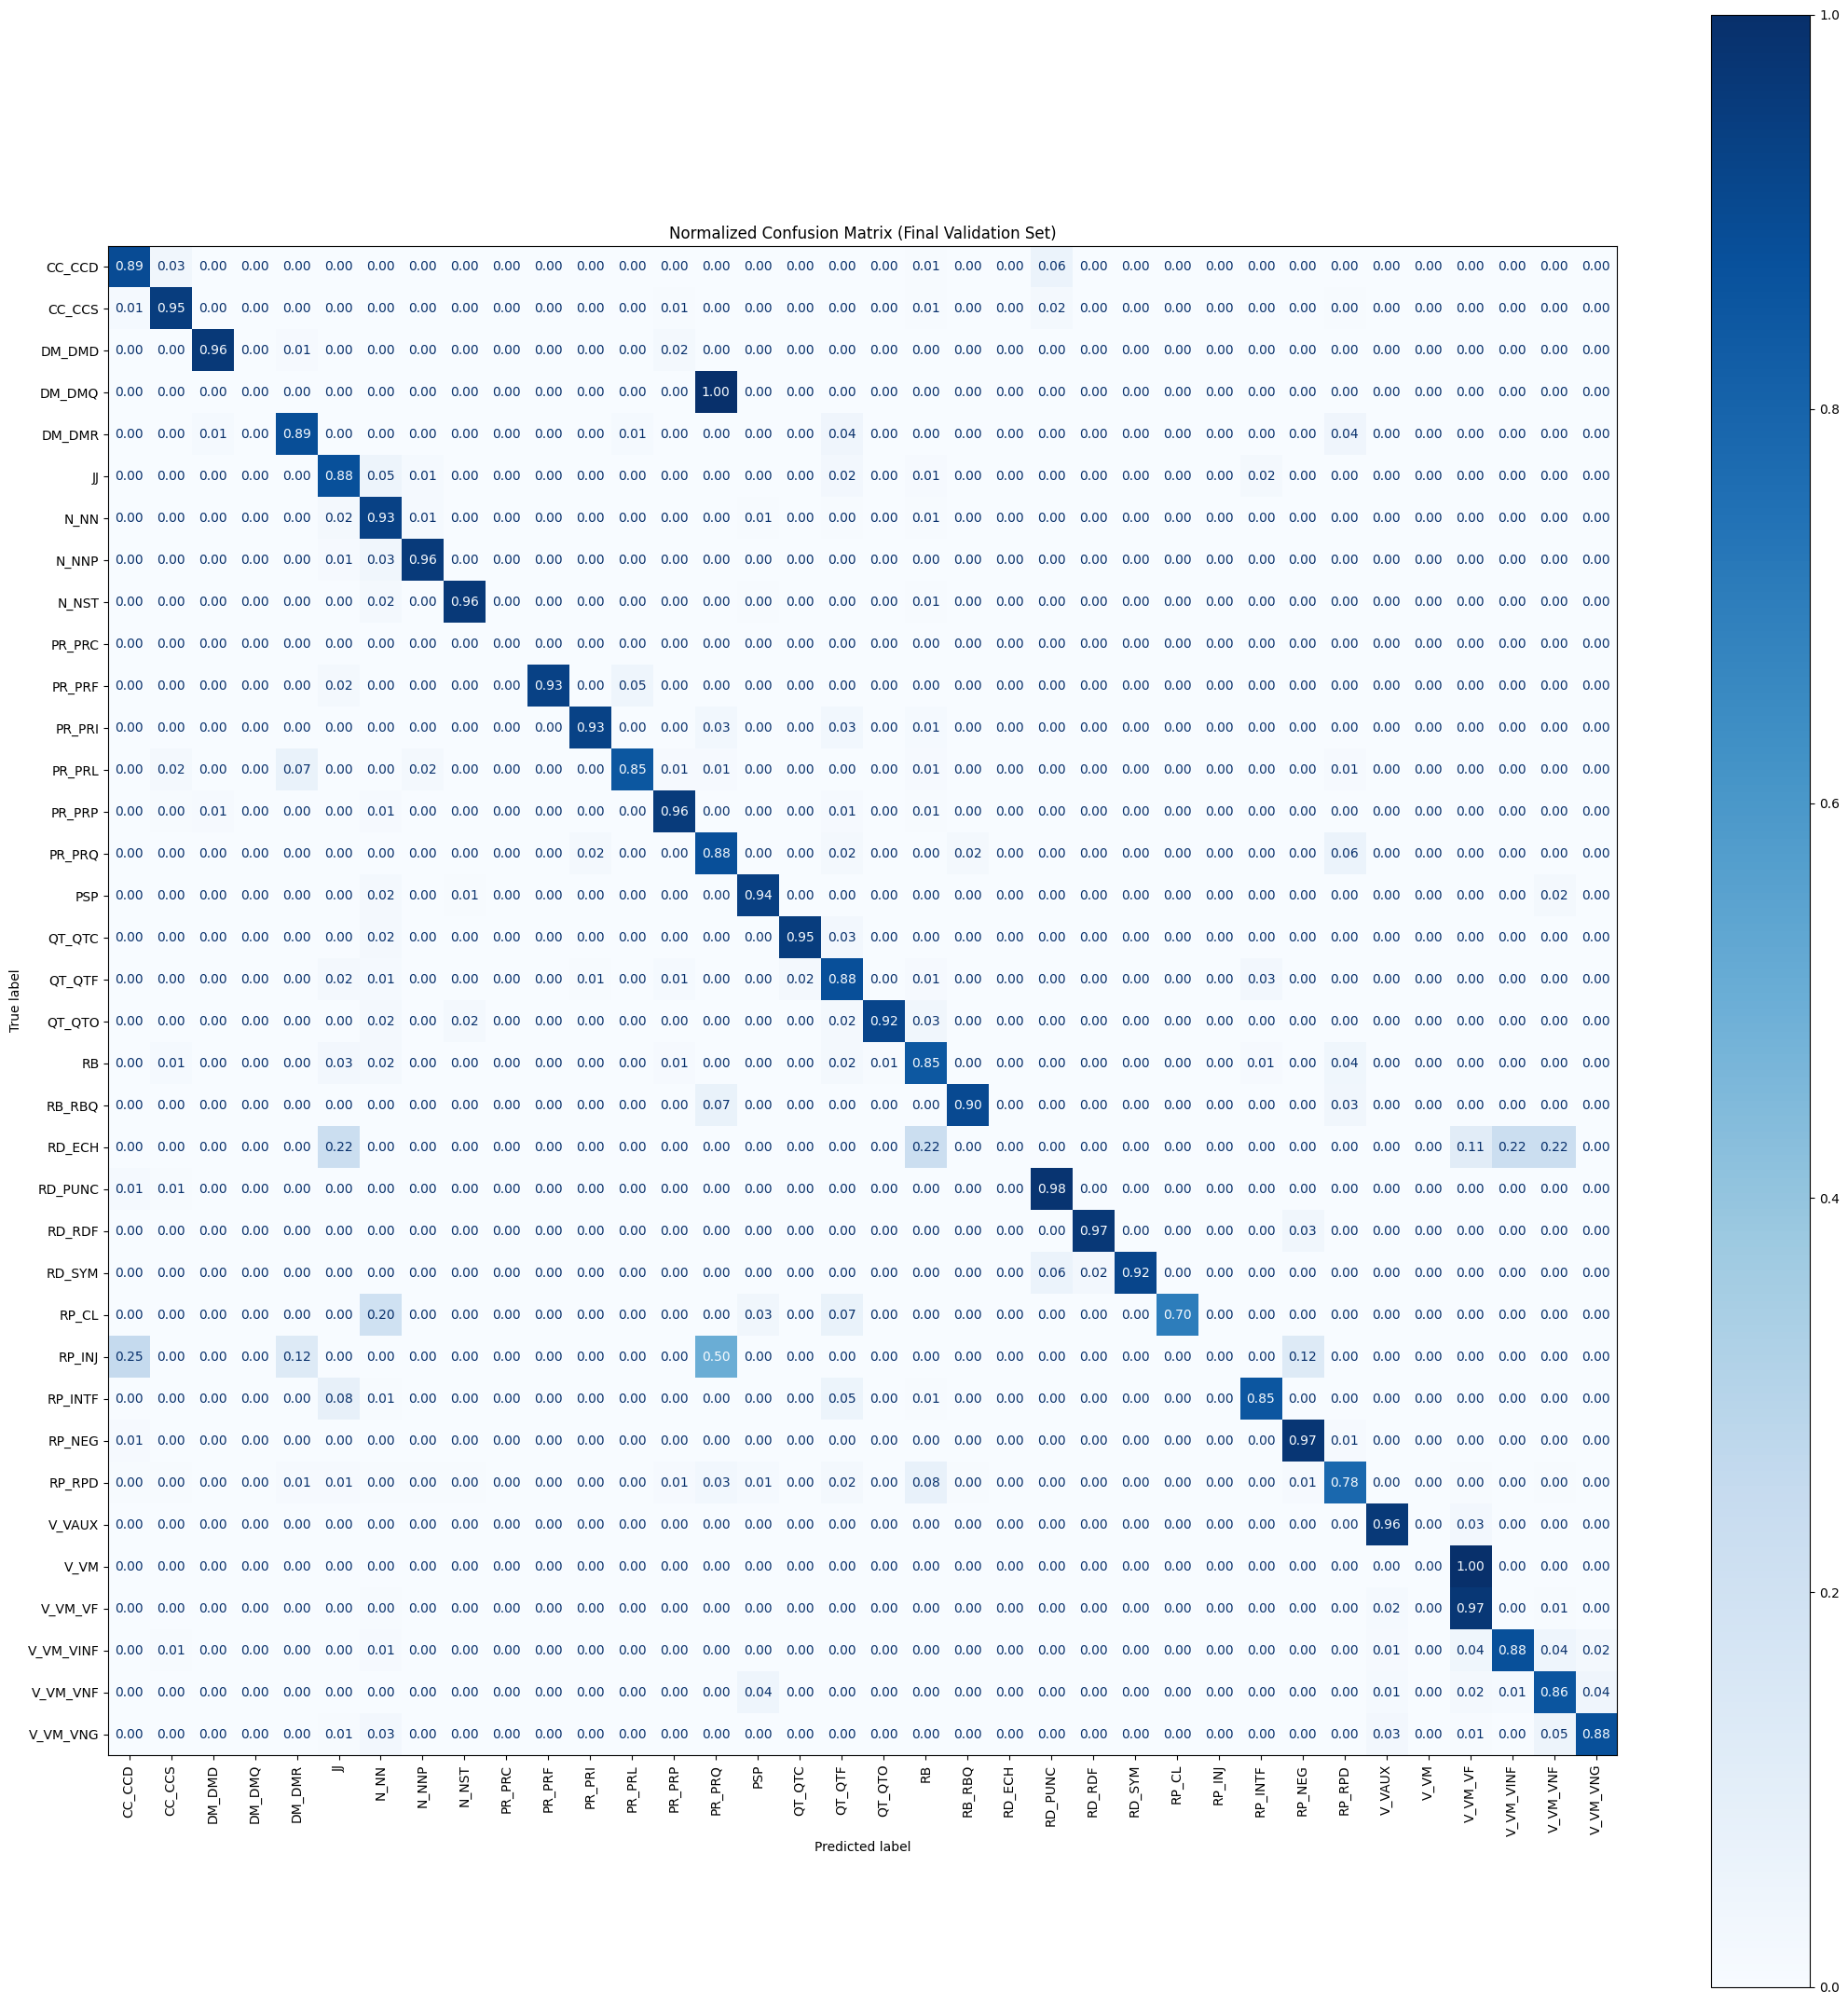

In [47]:
print("\n--- Evaluating Final Model on Final Validation Set (used during training) ---")
if len(final_validation_dataset) > 0: 
    validation_metrics_after_training = analyze_evaluation_results(final_trainer, final_validation_dataset, idx2tag, dataset_name="Final Validation Set")
else:
    print("No final validation data available for evaluation.")


**Evaluation on Test data(100 heldout data)**


--- Evaluating Final Model on Held-Out Final Test Dataset ---

--- Analyzing Held-Out Final Test Set Results ---


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Held-Out Final Test Set Metrics: {'eval_loss': 0.3437163829803467, 'eval_accuracy': 0.9181739879414298, 'eval_f1': 0.9181739879414298, 'eval_precision_CC_CCD': 0.8888888888888888, 'eval_recall_CC_CCD': 0.8888888888888888, 'eval_f1_CC_CCD': 0.8888888888888888, 'eval_precision_CC_CCS': 0.8275862068965517, 'eval_recall_CC_CCS': 1.0, 'eval_f1_CC_CCS': 0.9056603773584906, 'eval_precision_DM_DMD': 1.0, 'eval_recall_DM_DMD': 1.0, 'eval_f1_DM_DMD': 1.0, 'eval_precision_DM_DMQ': 0.0, 'eval_recall_DM_DMQ': 0.0, 'eval_f1_DM_DMQ': 0.0, 'eval_precision_DM_DMR': 1.0, 'eval_recall_DM_DMR': 0.75, 'eval_f1_DM_DMR': 0.8571428571428571, 'eval_precision_JJ': 0.7301587301587301, 'eval_recall_JJ': 0.7796610169491526, 'eval_f1_JJ': 0.7540983606557377, 'eval_precision_N_NN': 0.9530386740331491, 'eval_recall_N_NN': 0.9249329758713136, 'eval_f1_N_NN': 0.9387755102040816, 'eval_precision_N_NNP': 0.948051948051948, 'eval_recall_N_NNP': 0.9125, 'eval_f1_N_NNP': 0.929936305732484, 'eval_precision_N_NST': 1.0, 'eval

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

      CC_CCD       0.89      0.89      0.89        18
      CC_CCS       0.83      1.00      0.91        24
      DM_DMD       1.00      1.00      1.00        23
      DM_DMQ       0.00      0.00      0.00         0
      DM_DMR       1.00      0.75      0.86         4
          JJ       0.73      0.78      0.75        59
        N_NN       0.95      0.92      0.94       373
       N_NNP       0.95      0.91      0.93        80
       N_NST       1.00      0.95      0.98        21
      PR_PRC       0.00      0.00      0.00         0
      PR_PRF       0.00      0.00      0.00         0
      PR_PRI       0.00      0.00      0.00         0
      PR_PRL       1.00      0.71      0.83         7
      PR_PRP       0.94      0.93      0.93        54
      PR_PRQ       0.86      1.00      0.92         6
         PSP       0.87      0.94      0.91        36
      QT_QTC       0.84      0.88      0.86        24
   

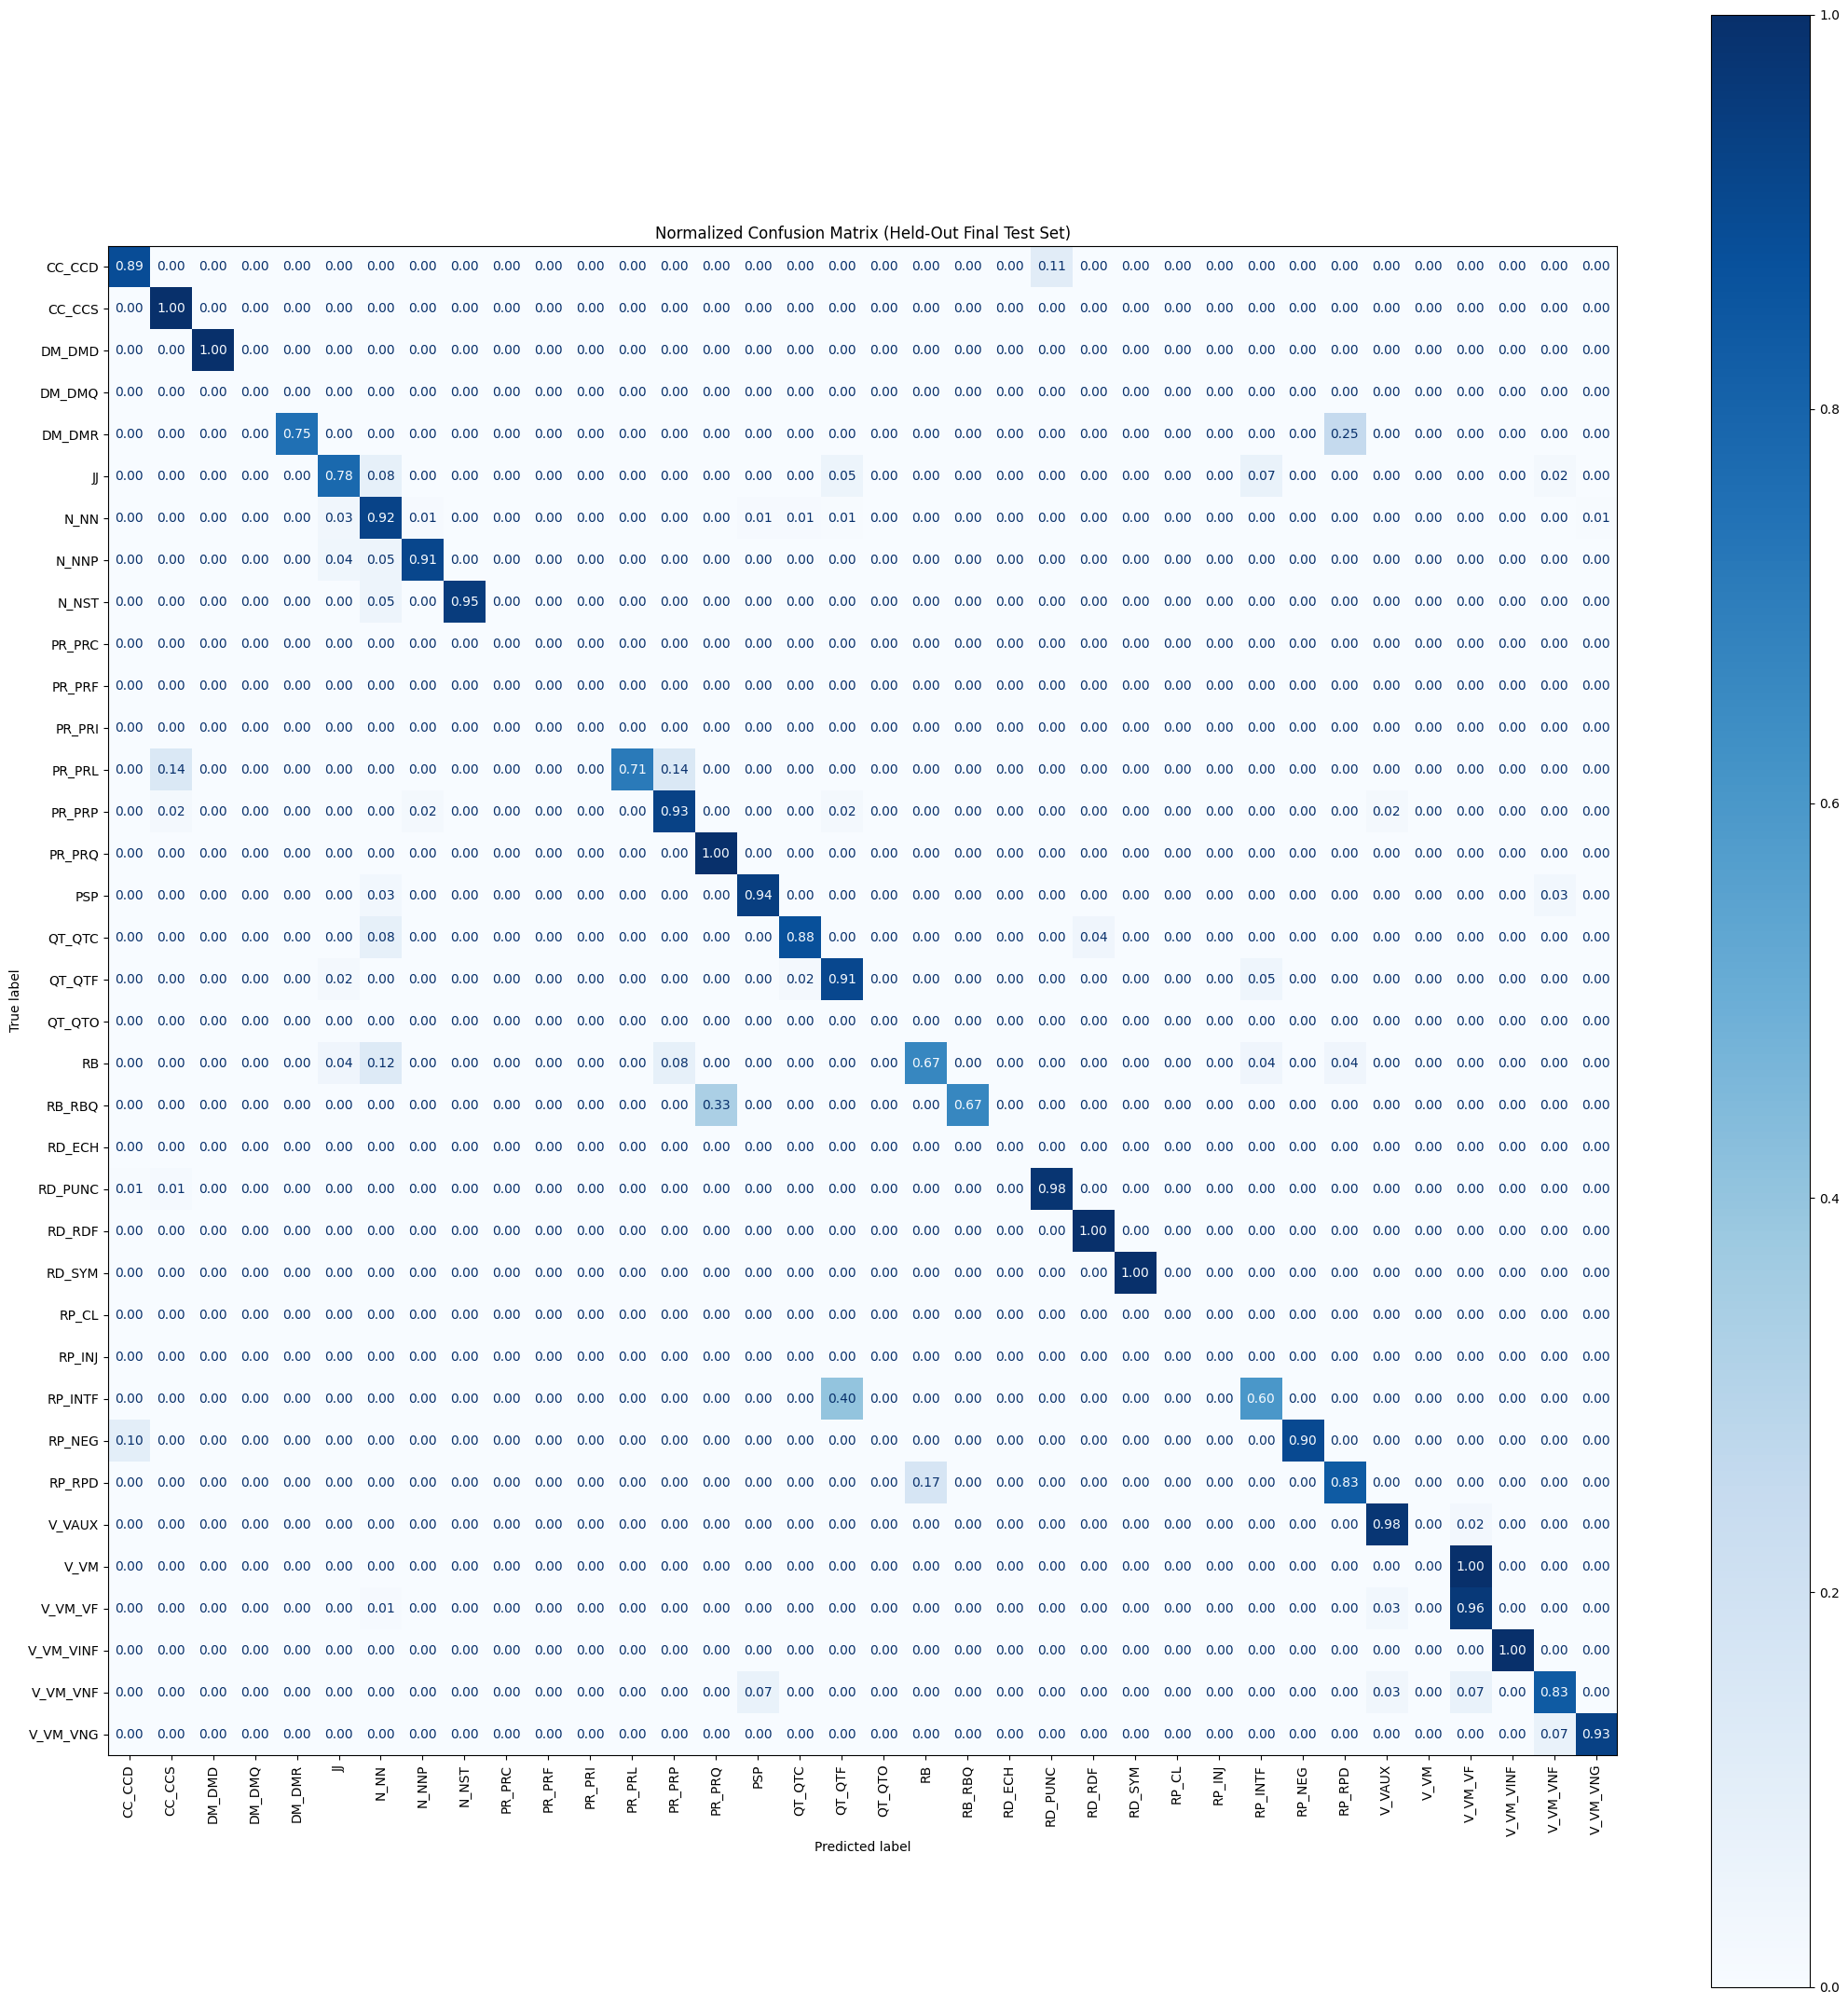

In [46]:
# NOTE: Because load_best_model_at_end=True was used in final training,
# the model state loaded into final_trainer.model after train() is the state
# that achieved the best eval_accuracy on the *final validation set*.

print("\n--- Evaluating Final Model on Held-Out Final Test Dataset ---")

if len(tokenized_final_test_dataset) > 0:
    test_metrics = analyze_evaluation_results(final_trainer, tokenized_final_test_dataset, idx2tag, dataset_name="Held-Out Final Test Set")
else:
    print("No final test data available for evaluation.")


# 9. Save the Final Trained Model

In [57]:
final_model_save_path_dir = "/kaggle/working/saved_model_final" 
final_model_save_path_zip = f"{final_model_save_path_dir}.zip" 

print(f"\nSaving final model trained to directory '{final_model_save_path_dir}'...")
final_trainer.save_model(final_model_save_path_dir)
print("Final model saved to directory.")

tokenizer.save_pretrained(final_model_save_path_dir)
print("Tokenizer saved to directory.")

print(f"\nCompressing '{final_model_save_path_dir}' into '{final_model_save_path_zip}'...")

import zipfile
import os
import shutil

try:
    with zipfile.ZipFile(final_model_save_path_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(final_model_save_path_dir):
            for file in files:
                file_path = os.path.join(root, file)

                arcname = os.path.relpath(file_path, final_model_save_path_dir)
                zipf.write(file_path, arcname)
    print("Compression complete.")


except Exception as e:
    print(f"Error during zipping: {e}")
    print("The original directory was not removed.")




Saving final model trained to directory '/kaggle/working/saved_model_final'...
Final model saved to directory.
Tokenizer saved to directory.

Compressing '/kaggle/working/saved_model_final' into '/kaggle/working/saved_model_final.zip'...
Compression complete.


In [55]:
# # # Optional cleanup
# import shutil
# checkpoint_dir = "/kaggle/working/"
# if os.path.exists(checkpoint_dir):
#      for item in os.listdir(checkpoint_dir):
#          if item.startswith("saved_mocel_final"):
#              print(f"  Removing checkpoint dir: {item}")
#              try: shutil.rmtree(os.path.join(checkpoint_dir, item))
#              except OSError as e: print(f"Error removing directory {item}: {e}")

  Removing checkpoint dir: saved_mocel_final
  Removing checkpoint dir: saved_mocel_final.zip
Error removing directory saved_mocel_final.zip: [Errno 20] Not a directory: '/kaggle/working/saved_mocel_final.zip'


In [56]:
import os

zip_path = "/kaggle/working/final_model.zip"
os.remove(zip_path)
zip_path = "/kaggle/working/saved_mocel_final.zip"
os.remove(zip_path)

# 10.Predictions

In [60]:
def normalize_text(word):
    """Normalizes specific quote characters."""
    return word.replace('\u2018', "'").replace('\u2019', "'").replace('\u200c', '') # Also normalize zero-width non-joiner

def tokenize_chunk(chunk):
    """
    Splits a text chunk into potential words and punctuation tokens based on specific Bengali linguistic patterns.
    This is a custom tokenization logic, more complex than simple whitespace splitting.
    """
    # (a) First: if the chunk ends with punctuation that should be separate, split them off.
    # Handles terminal punctuation like comma, period, question mark, etc.
    punct_pattern = r"([,\.।;!?\u0965]+)$"
    m = re.search(r"(.*)(" + punct_pattern + r")", chunk)
    if m:
        main_part = m.group(1)
        punctuation = m.group(2)
        tokens = []
        if main_part:
            # Recursively tokenize the main part
            tokens.extend(tokenize_chunk(main_part))
        # Add the punctuation characters as separate tokens
        tokens.extend(list(punctuation))
        return tokens

    # (b) If the chunk contains a dash and a quote together (with no spaces), leave it unchanged.
    # Handles cases like words with dashes and quotes attached, keeps them as one token.
    if re.search(r"([-–]['‘’]|['‘’][-–])", chunk):
        return [chunk]

    # (a)+(d) Try matching a word pattern that allows optional boundary quotes and hyphens/quotes within the word.
    # This pattern tries to identify standard Bengali words, potentially with internal hyphens/quotes.
    word_pattern = re.compile(
        r"^(?P<pre>['‘’]?)(?P<body>[\u0980-\u09FF]+(?:[-–'‘’][\u0980-\u09FF]+)*)(?P<post>['‘’]?)$"
    )
    m = word_pattern.match(chunk)
    if m:
        pre = m.group("pre")
        body = m.group("body")
        post = m.group("post")
        # Special case for balanced quotes around the whole word (like 'word')
        if pre == "‘" and post == "’" and len(chunk) > 2:
            return ["‘", body, "’"]
        # Otherwise, treat the entire matched pattern as a single word token
        return [chunk]

    # Fallback: If none of the specific patterns match, split the chunk by character,
    # grouping consecutive non-punctuation characters.
    # This handles unexpected tokens or complex structures by splitting them into smaller units.
    punctuation_set = {"-", "–", "'", "‘", "’", '"', ",", ".", "।", ";", "!", "?", "॥"}
    tokens = []
    current = ""
    for char in chunk:
        if char in punctuation_set:
            if current:
                tokens.append(current)
                current = ""
            tokens.append(char)
        else:
            current += char
    if current:
        tokens.append(current)
    return tokens

def extract_bengali_words(text):
    """
    Splits text by whitespace, then tokenizes each chunk using tokenize_chunk(), flattens the result.
    Normalization is now handled within the predict_sentence function for consistency with tokenization.
    """
    chunks = text.split()
    tokens = []
    for chunk in chunks:
        # Apply tokenize_chunk to each whitespace-separated chunk
        tokens.extend(tokenize_chunk(chunk))
    # Normalization is done later per token just before tokenizer
    return tokens # Return raw tokens from chunking

def predict_sentence(text, model, tokenizer, idx2tag, max_length=128):
    """
    Predicts POS tags for a raw text sentence using the trained model,
    incorporating custom text splitting and chunking for prediction.

    Args:
        text (str): The input sentence string.
        model (PreTrainedModel): The trained token classification model.
        tokenizer (PreTrainedTokenizer): The tokenizer used with the model.
        idx2tag (dict): Mapping from tag IDs to tag strings.
        max_length (int): Maximum sequence length for model input.

    Returns:
        tuple: A tuple containing:
            - list: Original word/token units from extract_bengali_words.
            - list: Predicted tag strings aligned to those units.
    """
    # Use the custom word extraction logic
    processed_words = extract_bengali_words(text)

    if not processed_words:
        return [], [] # Return empty lists if no words/tokens are extracted

    # Process words in chunks that fit within the model's max_length
    # The tokenizer will handle padding/truncation within each chunk's max_length
    # Note: The prediction chunking here is different from training batching.
    # This is to ensure potentially long sentences are processed piece by piece.
    # A prediction max_chunk_length was used in your old code, let's use max_length directly here
    # assuming tokenizer handles max_length per input sequence.

    word_list = []
    tag_list = []

    # Tokenize and predict for the entire sequence of processed_words at once,
    # letting the tokenizer handle potential overall truncation if > max_length
    # If the total number of processed_words is very large, manual chunking might still be needed,
    # but let's simplify and use the tokenizer's max_length first as it's handled internally.

    # Normalize words before tokenization
    normalized_words = [normalize_text(w) for w in processed_words]

    encoding = tokenizer(
        normalized_words,
        is_split_into_words=True, 
        truncation=True,        
        padding="max_length",   
        max_length=max_length,  
        return_tensors="pt"     
    ).to(model.device)

    # Perform inference
    model.eval()
    with torch.no_grad(): 
        outputs = model(**encoding)

    # Get predicted tag IDs
    logits = outputs.logits # Logits shape: (batch_size, sequence_length, num_labels)
    predictions = torch.argmax(logits, dim=-1)[0].cpu().numpy() # Get predictions for the first item in batch (shape: sequence_length)

    # Align predictions to original words using word_ids
    word_ids = encoding.word_ids(batch_index=0) # Get word IDs for the single item in batch

    # Create aligned list of (word, predicted_tag)
    aligned_predictions = []
    current_word_index = -1

    # Iterate through the tokens in the tokenized sequence
    for token_idx, word_id in enumerate(word_ids):
         # Check if this token corresponds to an original word (not None)
         # and if it's the *first* token of an original word (word_id != previous word_id)
         if word_id is not None and word_id != current_word_index:
             # This token is the first part of a new original word
             current_word_index = word_id

             # Get the predicted tag ID for this specific token index
             predicted_id = predictions[token_idx].item()

             # Convert ID to tag string using the mapping
             try:
                 predicted_tag = idx2tag[predicted_id]
             except KeyError:
                 # Handle cases where a predicted ID is not in the idx2tag mapping (shouldn't happen normally)
                 predicted_tag = "UNK_ID"
                 print(f"Warning: Predicted UNK ID {predicted_id} encountered.")


             # Get the original word corresponding to this word_id
             # Ensure the word_id is within the bounds of the original processed_words list
             if current_word_index < len(processed_words):
                 original_word = processed_words[current_word_index]
                 aligned_predictions.append((original_word, predicted_tag))
             else:
                 # This could happen if truncation in tokenization is complex
                 # or there's an issue with word_ids mapping
                 print(f"Warning: word_id {current_word_index} out of bounds for processed_words (len {len(processed_words)}). Skipping.")
                 # Optionally add a placeholder or handle differently
                 # aligned_predictions.append((f"TRUNC_WORD_{current_word_index}", predicted_tag))


    # Extract the lists of words and tags from the aligned pairs
    # This ensures the word list matches the number of predictions we successfully aligned
    word_list = [item[0] for item in aligned_predictions]
    tag_list = [item[1] for item in aligned_predictions]


    # Note on potential mismatches: If the total sequence of tokens for processed_words
    # exceeds max_length, truncation occurs. This means the last original words might
    # not have any corresponding tokens in the truncated sequence, and thus won't
    # appear in the word_ids or get a prediction. The returned word_list and tag_list
    # will only contain words that had at least their first token within the max_length limit.
    # If max_length=128 is sufficient for typical Bengali sentences, this should be fine.
    # For very long texts, you might need to re-implement chunking here like your old code.

    return word_list, tag_list





In [61]:
final_model_path_for_prediction = "/kaggle/working/saved_model_final" # This should point to the directory path

print(f"\n--- Loading Final Model for Prediction from '{final_model_path_for_prediction}' ---")
try:
    # Load the model and tokenizer from the saved directory
    loaded_model = AutoModelForTokenClassification.from_pretrained(final_model_path_for_prediction)
    loaded_tokenizer = AutoTokenizer.from_pretrained(final_model_path_for_prediction)

    loaded_model.to(device)

    print("Final model and tokenizer loaded successfully.")

    loaded_model.eval()

    sample_text = """আজ বারি ঝরে ঝরঝর ভরা বাদরে ,
আকাশ-ভাঙা আকুল ধারা কোথাও না ধরে।।
শালের বনে থেকে থেকে ঝড় দোলা দেয় হেঁকে হেঁকে,
জল ছুটে যায় এঁকে বেঁকে মাঠের ‘পরে।
আজ মেঘের জটা উড়িয়ে দিয়ে নৃত্য কে করে।।
ওরে বৃষ্টিতে মোর ছুটেছে মন, লুটেছে এই ঝড়ে–
বুক ছাপিয়ে তরঙ্গ মোর কাহার পায়ে পড়ে।
অন্তরে আজ কী কলরোল, দ্বারে দ্বারে ভাঙল আগল–
হৃদয়-মাঝে জাগল পাগল আজি ভাদরে।
আজ এমন ক’রে কে মেতেছে বাহিরে ঘরে।।"""

    print(f"\n--- Predicting POS tags for sample text ---")
    print(f"Sample Text: {sample_text}")

    predicted_words, predicted_tags = predict_sentence(
        sample_text,
        loaded_model,
        loaded_tokenizer,
        idx2tag 
    )

    print("\nPrediction Results:")
    if len(predicted_words) == len(predicted_tags):
        for w, t in zip(predicted_words, predicted_tags):
            print(f"{w}: {t}")
    else:
        print("Warning: Mismatch between number of words and predicted tags.")
        print("Words:", predicted_words)
        print("Predicted Tags:", predicted_tags)


except Exception as e:
    print(f"\nError loading model or making prediction: {e}")
    print(f"Please ensure the directory '{final_model_path_for_prediction}' exists and contains the model and tokenizer files.")


--- Loading Final Model for Prediction from '/kaggle/working/saved_model_final' ---
Final model and tokenizer loaded successfully.

--- Predicting POS tags for sample text ---
Sample Text: আজ বারি ঝরে ঝরঝর ভরা বাদরে ,
আকাশ-ভাঙা আকুল ধারা কোথাও না ধরে।।
শালের বনে থেকে থেকে ঝড় দোলা দেয় হেঁকে হেঁকে,
জল ছুটে যায় এঁকে বেঁকে মাঠের ‘পরে।
আজ মেঘের জটা উড়িয়ে দিয়ে নৃত্য কে করে।।
ওরে বৃষ্টিতে মোর ছুটেছে মন, লুটেছে এই ঝড়ে–
বুক ছাপিয়ে তরঙ্গ মোর কাহার পায়ে পড়ে।
অন্তরে আজ কী কলরোল, দ্বারে দ্বারে ভাঙল আগল–
হৃদয়-মাঝে জাগল পাগল আজি ভাদরে।
আজ এমন ক’রে কে মেতেছে বাহিরে ঘরে।।

Prediction Results:
আজ: N_NN
বারি: N_NN
ঝরে: V_VM_VF
ঝরঝর: JJ
ভরা: V_VM_VNF
বাদরে: N_NN
,: RD_PUNC
আকাশ-ভাঙা: JJ
আকুল: JJ
ধারা: N_NN
কোথাও: PR_PRI
না: RP_NEG
ধরে: V_VM_VNF
।: RD_PUNC
।: RD_PUNC
শালের: N_NN
বনে: N_NN
থেকে: PSP
থেকে: V_VM_VNF
ঝড়: N_NN
দোলা: N_NN
দেয়: V_VAUX
হেঁকে: V_VM_VNF
হেঁকে: V_VM_VNF
,: RD_PUNC
জল: N_NN
ছুটে: V_VM_VF
যায়: V_VAUX
এঁকে: V_VM_VNF
বেঁকে: V_VM_VNF
মাঠের: N_NN
‘পরে: RD_PUNC
।: RD_PUNC
আজ: